# **First** autoencoder

In [1]:
import numpy as np
import torch
import torch.nn as nn

from DATA_generator import *

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#using lorenzos code from R
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

In [2]:
N_Samples=400
N_PeriodicGenes=20
N_NonPeriodicGenes=0
N_Genes=N_PeriodicGenes+N_NonPeriodicGenes

E , true_phases, alpha=NonUniformDataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes )
#E , true_phases, alpha=DataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes )

DATA=torch.from_numpy(E)
DATA=DATA.float()


Select gene you are interested setting varaible g in order to plot data, and supposed distribution

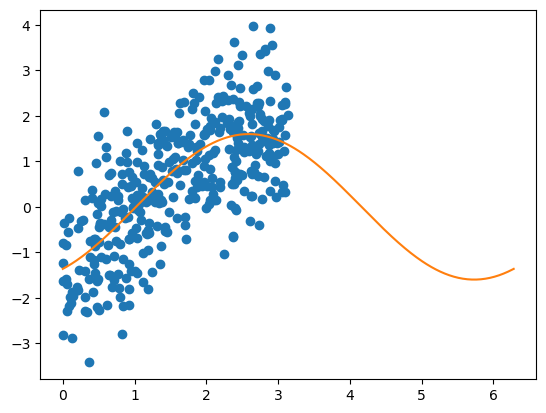

In [3]:
g=0
if g < N_PeriodicGenes:
    a=alpha[g,:]
    x=np.linspace(0,2*np.pi, 400)
    def f(x):
        return np.cos(x)*a[0]+ np.sin(x)*a[1]
    plt.plot(true_phases, E[g,:].reshape((400,1)), 'o',x,f(x))
else:
    plt.plot(true_phases, E[g,:].reshape((400,1)), 'o')



## PCA

In [4]:
Et=np.transpose(E)
pca=PCA(n_components=2)
pca.fit(Et)

/Users/salati/anaconda3/envs/AE-env/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


PCA(n_components=2)

In [5]:
pca.explained_variance_ratio_
PCA_base=pca.components_
PCA_base=np.array(PCA_base)
print('The two vectors are orthogonal, the scalar priduct is: ',np.matmul(PCA_base[0,:] ,PCA_base[1,:]) )


The two vectors are orthogonal, the scalar priduct is:  2.5890747878953846e-16


In [6]:
pca_points=pca.fit_transform(Et)

/Users/salati/anaconda3/envs/AE-env/lib/python3.10/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


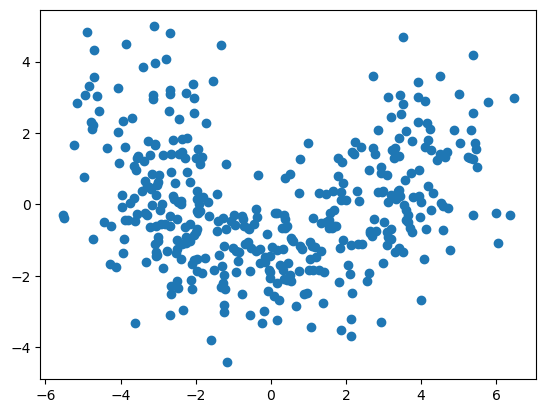

In [7]:
plt.plot(pca_points[:,0] , pca_points[:,1], 'o')

In [8]:
PCA_phi=np.arctan2(pca_points[:,0],pca_points[:,1])

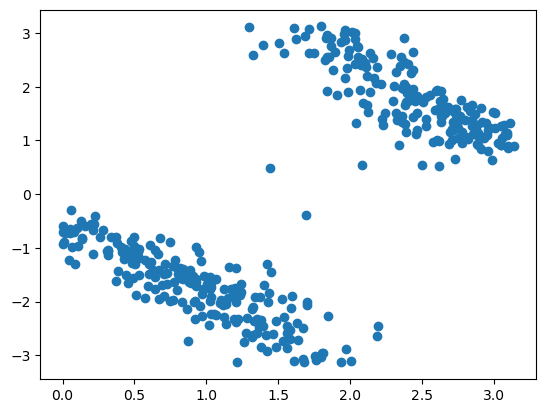

In [9]:
plt.plot(true_phases,PCA_phi, 'o')

## Torch Linear

### Setting the network

In [10]:
PCA_tensor=torch.tensor(PCA_base)
PCA_tensor=PCA_tensor.float()

In [11]:
class LinearEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
           
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        decoded=self.decoder(encoded)

        return decoded

Here I create an instance of the class LinearEncoder and define other important stuff like the loss function

In [12]:
model = LinearEncoder()
criterion= nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.0001)


Adding the GPU stuff

In [13]:
#for GPU use this block

#device = torch.device('mps')
#E_t=torch.from_numpy(E)
#E_t=E_t.float()
#DATA=torch.tensor(E_t,  device=device)
#model.to(device)


# for CPU keep this line
DATA=torch.from_numpy(E)
DATA=DATA.float()

Training cycle

In [14]:
#recon= reconstruction of the input
num_epochs=200
outputs=[]

for epoch in range(num_epochs):
 
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=model(input)
    loss=criterion(recon,input)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #added this line to compare with the circular model, thisline block the convergence
  if loss.item() < 0.0005 :
    break
  if (epoch % 10 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 1.322980284690857
epoch  10 Loss 1.3451054096221924
epoch  20 Loss 1.3646234273910522
epoch  30 Loss 1.3777164220809937
epoch  40 Loss 1.3855993747711182
epoch  50 Loss 1.3900585174560547
epoch  60 Loss 1.3924534320831299
epoch  70 Loss 1.393664836883545
epoch  80 Loss 1.3942205905914307
epoch  90 Loss 1.3944244384765625
epoch  100 Loss 1.39445161819458
epoch  110 Loss 1.3943984508514404
epoch  120 Loss 1.3943126201629639
epoch  130 Loss 1.3942217826843262
epoch  140 Loss 1.3941367864608765
epoch  150 Loss 1.3940602540969849
epoch  160 Loss 1.393998384475708
epoch  170 Loss 1.3939480781555176
epoch  180 Loss 1.3939083814620972
epoch  190 Loss 1.3938748836517334


Grabbing the weights of the first layer which are the analogous of the eigenvectors in PCA

In [15]:
encoder_base=model.encoder.weight
#print(encoder_base)
decoder_base=model.decoder.weight
#print(decoder_base)

Checking how the scalar product of the two vectors of the "basis" is

In [16]:
torch.dot(encoder_base[0,:],encoder_base[1,:] )

tensor(-8.7667e-06, grad_fn=<DotBackward0>)

In [17]:
NNphases=np.zeros((N_Samples,2))
for sample in range(N_Samples):
  temp=torch.matmul(encoder_base, DATA[:,sample]).detach().numpy()
  NNphases[sample,:]=temp

### Plots

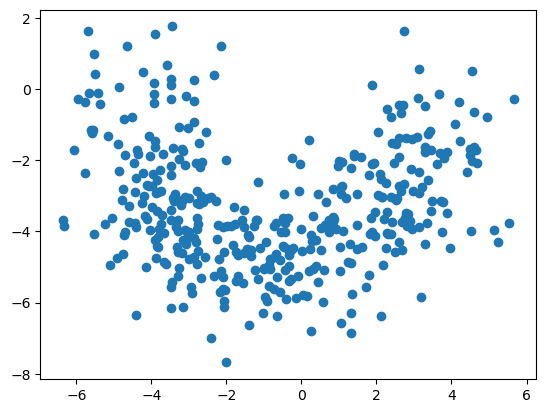

In [18]:
plt.plot(NNphases[:,0], NNphases[:,1],'o')

In [19]:
inf_phases=np.arctan2( NNphases[:,0],NNphases[:,1] )

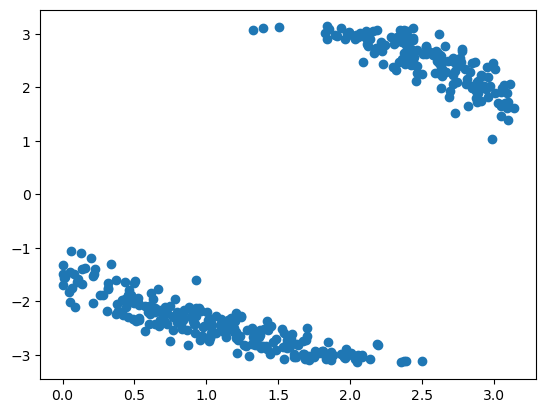

In [20]:
plt.plot(true_phases,inf_phases,'o')

## Adding the "circular" activation function

### Setting the network

In [21]:
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(N_Genes, 2,bias=False)
           )
        self.decoder = nn.Sequential(
            nn.Linear(2, N_Genes,bias=False)
           )
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)
        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 

In [22]:
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
    
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)
        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 

In [23]:
circ_model=CircularEncoder()
criterion2= nn.MSELoss()
optimizer2 = torch.optim.Adam(circ_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer2 = torch.optim.SGD(circ_model.parameters(),lr=0.001)


In [24]:
#recon= reconstruction of the input
num_epochs=100
outputs=[]

for epoch in range(num_epochs):
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=circ_model(input)
    loss=criterion2(recon,input)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
  if (epoch % 5 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 2.1173338890075684
epoch  5 Loss 1.5661263465881348
epoch  10 Loss 1.4891375303268433
epoch  15 Loss 1.4835853576660156
epoch  20 Loss 1.488882303237915
epoch  25 Loss 1.4947439432144165
epoch  30 Loss 1.5007612705230713
epoch  35 Loss 1.50498366355896
epoch  40 Loss 1.5074615478515625
epoch  45 Loss 1.5096362829208374
epoch  50 Loss 1.5119816064834595
epoch  55 Loss 1.5144579410552979
epoch  60 Loss 1.5169181823730469
epoch  65 Loss 1.519286036491394
epoch  70 Loss 1.5214884281158447
epoch  75 Loss 1.5232713222503662
epoch  80 Loss 1.5239284038543701
epoch  85 Loss 1.5222620964050293
epoch  90 Loss 1.5164767503738403
epoch  95 Loss 1.5059759616851807


In [25]:
circ_encoder_base=circ_model.encoder.weight
#print(encoder_base)
circ_decoder_baseC=circ_model.decoder.weight
#print(decoder_base)

After having the values of the weight, in order to find the values of the neurons, i just reconstruct waht happens to the input until the the bottle neck (encoder linear layer + unit circle projection)

In [26]:
NNphasesC=np.zeros((N_Samples,2))
for sample in range(N_Samples):
  temp=torch.matmul(circ_encoder_base, DATA[:,sample]).detach().numpy()
  NNphasesC[sample,:]=temp
  NNphasesC[sample,:] /= np.linalg.norm(NNphasesC[sample,:])

np.linalg.norm( NNphases[9,:] )

6.861782141981478

In [27]:
#plt.plot(NNphasesC[:,0], NNphasesC[:,1],'o')

In [28]:
inf_phasesC=np.arctan2( NNphasesC[:,0],NNphasesC[:,1] )

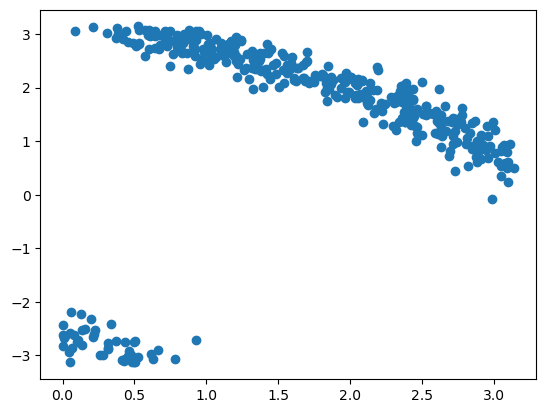

In [29]:
plt.plot(true_phases,inf_phasesC,'o')